## - обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
## - оценить рост точности при увеличении ширины сети (больше ядер)
## - оценить рост точности при увеличении глубины сети (больше слоев)
## - сравнить с точностью полносвязной сети для этой выборки

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing

# keras.losses.SparseCategoricalCrossentropy()
from tensorflow.keras.losses import categorical_crossentropy
# tensorflow.keras.metrics.accuracy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [29]:
# загрузка тренировочных и тестовых данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# конвертация чисел из uint8 в float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# нормализация данных [0, 1]
x_train /= 255 
x_test /= 255 

# трансформация лейблов в one-hot encoding
y_train = to_categorical(y_train, 10) 
y_test = to_categorical(y_test, 10) 

# изменение размерности массива в 4D массив
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

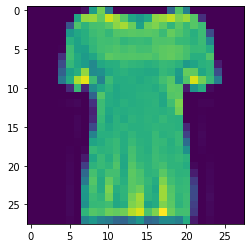

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
plt.imshow(x_train[10,:,:])
plt.show()
print(y_train[10])

In [31]:
y_train[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [32]:
x_train[202,150:160]

array([], shape=(0, 28, 1), dtype=float32)

In [33]:
# Размер набора данных для обучения
x_train.shape

(60000, 28, 28, 1)

### Соберем сеть

In [39]:
batch_size=32
epochs = 5
num_predictions = 20
labels = {
        0: 'футболка',
        1: 'брюки',
        2: 'свитер',
        3: 'платье',
        4: 'куртка',
        5: 'сандалии',
        6: 'рубашка',
        7: 'кроссовки',
        8: 'сумка',
        9: 'ботинки',
            }
len(labels)

10

In [ ]:


# конфигурирование слоев нейросети
model = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout( 0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# полносвязные слои нейронной сети
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels)))
model.add(Activation('softmax'))

# инициализация RMSprop optimizer
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# if not data_augmentation:
#     print('Не используется data augmentation')
#     model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True)
# else:
#     print('Использование data augmentation в реальном времени')
#     # Препроцессинг и data augmentation в реальном времени:
#     datagen = ImageDataGenerator(
#         featurewise_center=False,
#         samplewise_center=False,
#         featurewise_std_normalization=False,
#         samplewise_std_normalization=False,
#         zca_whitening=False, 
#         zca_epsilon=1e-06, 
#         rotation_range=0, 
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         shear_range=0., 
#         zoom_range=0., 
#         channel_shift_range=0.,
#         fill_mode='nearest',
#         cval=0.,
#         horizontal_flip=True,
#         vertical_flip=False,
#         rescale=None,
#         preprocessing_function=None,
#         data_format=None,
#         validation_split=0.0)

#     # запуск data augmentation через fit
#     #datagen.fit(x_train)

#     # запуск data augmentation через fit_generator
#     model.fit_generator(datagen.flow(x_train, y_train,
#                                      batch_size=batch_size),
#                         epochs=epochs,
#                         validation_data=(x_test, y_test),
#                         workers=4)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2021-08-10 19:47:57.289201: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-08-10 19:47:57.406878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-10 19:47:57.424831: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


Epoch 1/5
1875/1875 [==============================] - 87s 46ms/step - loss: 1.0000 - accuracy: 0.6274 - val_loss: 0.6013 - val_accuracy: 0.7754
Epoch 2/5
  86/1875 [>.............................] - ETA: 1:18 - loss: 0.6672 - accuracy: 0.7500

Сделаем предикт для примеров тестов

In [ ]:
N = 30
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()